 ## Seattle - Airbnb Data Set.



#### In order to get a better grip over the Airbnb data set. Lets wrangle it to get a better understanding, and prepare it to solve the Business Questions.


#### Business Questions:

##### How does number of reviews drive the Airbnb Prices in Seattle?
##### How competent and stable are the Airbnb prices dependent on popularity of a place?

In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

import seaborn as sns

import numba
from numba import cuda

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

from sklearn.metrics import fbeta_score, accuracy_score

from sklearn.linear_model import LinearRegression

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

from sklearn.metrics import r2_score, mean_squared_error

from sklearn.model_selection import GridSearchCV,cross_val_score, cross_validate
from sklearn.metrics import fbeta_score, make_scorer, SCORERS


#### Loading the Datasets

In [52]:
airbnb_listing_df = pd.read_csv('Data/seattle_kaggle_airbnb/listings.csv')

airbnb_calendar_df = pd.read_csv('Data/seattle_kaggle_airbnb/calendar.csv')

airbnb_reviews_df = pd.read_csv('Data/seattle_kaggle_airbnb/reviews.csv')

#### Finding the Rows and Columns in the Dataframes

In [4]:
airbnb_listing_df.shape

(3818, 92)

In [6]:
airbnb_calendar_df.shape

(1393570, 4)

In [7]:
airbnb_reviews_df.shape

(84849, 6)

#### Examning the dataframes

In [10]:
print(airbnb_listing_df.head())

        id                           listing_url       scrape_id last_scraped  \
0   241032   https://www.airbnb.com/rooms/241032  20160104002432   2016-01-04   
1   953595   https://www.airbnb.com/rooms/953595  20160104002432   2016-01-04   
2  3308979  https://www.airbnb.com/rooms/3308979  20160104002432   2016-01-04   
3  7421966  https://www.airbnb.com/rooms/7421966  20160104002432   2016-01-04   
4   278830   https://www.airbnb.com/rooms/278830  20160104002432   2016-01-04   

                                  name  \
0         Stylish Queen Anne Apartment   
1   Bright & Airy Queen Anne Apartment   
2  New Modern House-Amazing water view   
3                   Queen Anne Chateau   
4       Charming craftsman 3 bdm house   

                                             summary  \
0                                                NaN   
1  Chemically sensitive? We've removed the irrita...   
2  New modern house built in 2013.  Spectacular s...   
3  A charming apartment that sits at

In [11]:
airbnb_calendar_df.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [12]:
airbnb_reviews_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [67]:
features = airbnb_listing_df.columns.sort_values(ascending = True).tolist()

#### Converting price to float/integer

In [74]:
#pd.to_numeric(airbnb_listing_df.price, errors = "coerce")

#airbnb_listing_df.price.iloc[3122]

pd.to_numeric(airbnb_listing_df.price.str[1:], errors = "raise")

0        85.0
1       150.0
2       975.0
3       100.0
4       450.0
5       120.0
6        80.0
7        60.0
8        90.0
9       150.0
10       95.0
11       99.0
12      245.0
13      165.0
14      461.0
15      109.0
16       66.0
17       99.0
18      200.0
19      700.0
20      110.0
21       99.0
22      450.0
23       75.0
24      600.0
25      450.0
26      150.0
27       45.0
28      300.0
29       80.0
        ...  
3788    115.0
3789     60.0
3790    175.0
3791     85.0
3792    109.0
3793    109.0
3794    107.0
3795    200.0
3796     85.0
3797     70.0
3798     77.0
3799     65.0
3800    185.0
3801    108.0
3802    200.0
3803    250.0
3804    125.0
3805    100.0
3806    160.0
3807    109.0
3808    175.0
3809    120.0
3810    154.0
3811     65.0
3812     95.0
3813    359.0
3814     79.0
3815     93.0
3816     99.0
3817     87.0
Name: price, Length: 3818, dtype: float64

In [54]:
for feature in features:
    print(feature)
    print(airbnb_listing_df[feature][:5] , "\n")

accommodates
0     4
1     4
2    11
3     3
4     6
Name: accommodates, dtype: int64 

amenities
0    {TV,"Cable TV",Internet,"Wireless Internet","A...
1    {TV,Internet,"Wireless Internet",Kitchen,"Free...
2    {TV,"Cable TV",Internet,"Wireless Internet","A...
3    {Internet,"Wireless Internet",Kitchen,"Indoor ...
4    {TV,"Cable TV",Internet,"Wireless Internet",Ki...
Name: amenities, dtype: object 

availability_30
0    14
1    13
2     1
3     0
4    30
Name: availability_30, dtype: int64 

availability_365
0    346
1    291
2    220
3    143
4    365
Name: availability_365, dtype: int64 

availability_60
0    41
1    13
2     6
3     0
4    60
Name: availability_60, dtype: int64 

availability_90
0    71
1    16
2    17
3     0
4    90
Name: availability_90, dtype: int64 

bathrooms
0    1.0
1    1.0
2    4.5
3    1.0
4    2.0
Name: bathrooms, dtype: float64 

bed_type
0    Real Bed
1    Real Bed
2    Real Bed
3    Real Bed
4    Real Bed
Name: bed_type, dtype: object 

bedrooms
0 

In [58]:
#np.int(airbnb_listing_df.price)

airbnb_listing_df.price[1]

#df.ID = pd.to_numeric(df.ID, errors='coerce')

AttributeError: 'str' object has no attribute 'to_float'

In [29]:
no_nulls = set(airbnb_listing_df.columns[np.sum(airbnb_listing_df.isnull()) == 0])

no_nulls

{'accommodates',
 'amenities',
 'availability_30',
 'availability_365',
 'availability_60',
 'availability_90',
 'bed_type',
 'calculated_host_listings_count',
 'calendar_last_scraped',
 'calendar_updated',
 'cancellation_policy',
 'city',
 'country',
 'country_code',
 'description',
 'experiences_offered',
 'extra_people',
 'guests_included',
 'has_availability',
 'host_id',
 'host_url',
 'host_verifications',
 'id',
 'instant_bookable',
 'is_location_exact',
 'jurisdiction_names',
 'last_scraped',
 'latitude',
 'listing_url',
 'longitude',
 'market',
 'maximum_nights',
 'minimum_nights',
 'name',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'number_of_reviews',
 'picture_url',
 'price',
 'require_guest_phone_verification',
 'require_guest_profile_picture',
 'requires_license',
 'room_type',
 'scrape_id',
 'smart_location',
 'state',
 'street'}

#### A Set Columns Names missing more than 10% of their values missing.

In [19]:
set(airbnb_listing_df.columns[airbnb_listing_df.isnull().mean() > .03])

{'cleaning_fee',
 'first_review',
 'host_about',
 'host_acceptance_rate',
 'host_neighbourhood',
 'host_response_rate',
 'host_response_time',
 'last_review',
 'license',
 'medium_url',
 'monthly_price',
 'neighborhood_overview',
 'neighbourhood',
 'notes',
 'review_scores_accuracy',
 'review_scores_checkin',
 'review_scores_cleanliness',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_rating',
 'review_scores_value',
 'reviews_per_month',
 'security_deposit',
 'space',
 'square_feet',
 'summary',
 'thumbnail_url',
 'transit',
 'weekly_price',
 'xl_picture_url'}

In [51]:
airbnb_listing_df.isnull().mean().sort_values(ascending =False)

license                             1.000000
price                               1.000000
square_feet                         0.974594
monthly_price                       0.602672
security_deposit                    0.511262
weekly_price                        0.473808
notes                               0.420639
neighborhood_overview               0.270299
cleaning_fee                        0.269775
transit                             0.244631
host_about                          0.224987
host_acceptance_rate                0.202462
review_scores_accuracy              0.172342
review_scores_checkin               0.172342
review_scores_value                 0.171818
review_scores_location              0.171556
review_scores_cleanliness           0.171032
review_scores_communication         0.170508
review_scores_rating                0.169460
last_review                         0.164222
first_review                        0.164222
reviews_per_month                   0.164222
space     

#### Histogram Distribution of Neighbourhood Groups

Other neighborhoods    794
Capitol Hill           567
Downtown               530
Central Area           369
Queen Anne             295
Ballard                230
West Seattle           203
Rainier Valley         159
University District    122
Beacon Hill            118
Cascade                 89
Northgate               80
Delridge                79
Lake City               67
Magnolia                61
Seward Park             44
Interbay                11
Name: neighbourhood_group_cleansed, dtype: int64
Other neighborhoods    46.705882
Capitol Hill           33.352941
Downtown               31.176471
Central Area           21.705882
Queen Anne             17.352941
Ballard                13.529412
West Seattle           11.941176
Rainier Valley          9.352941
University District     7.176471
Beacon Hill             6.941176
Cascade                 5.235294
Northgate               4.705882
Delridge                4.647059
Lake City               3.941176
Magnolia                3.5882

Text(0.5,1,'# of Airbnb Listings in Neighbourhood Groups')

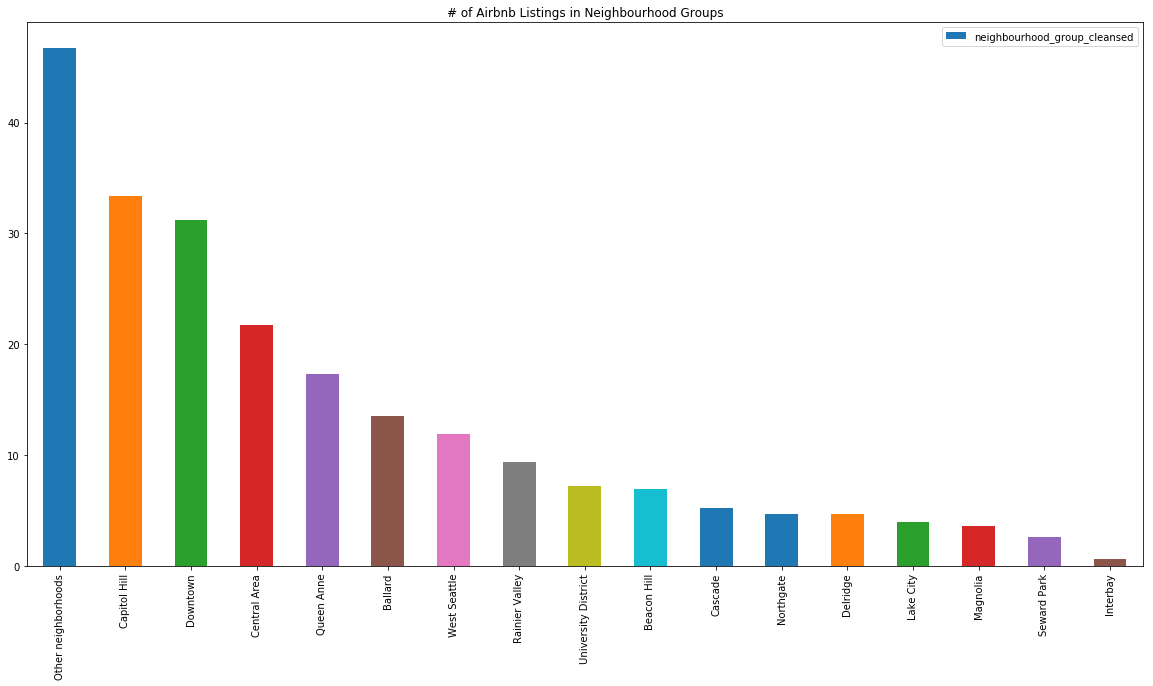

In [35]:
ngh_grp = airbnb_listing_df.neighbourhood_group_cleansed.value_counts().sort_values(ascending = False)
print(ngh_grp)

print(ngh_grp/ngh_grp.shape[0])

(ngh_grp/ngh_grp.shape[0]).plot(kind = "bar", figsize = (20,10), legend = True)
plt.title("# of Airbnb Listings in Neighbourhood Groups")

#### Understanding the Listing Data
###### List of neighbourhoods with highest Airbnb reviews in Seattle,WA

In [37]:
areas_and_reviews = airbnb_listing_df.groupby(by = ["number_of_reviews"])["neighbourhood_group_cleansed","neighbourhood_cleansed"].max()[::-1]
print(areas_and_reviews)


print(airbnb_listing_df.neighbourhood_group_cleansed.unique().tolist())


                  neighbourhood_group_cleansed     neighbourhood_cleansed
number_of_reviews                                                        
474                                   Downtown     International District
466                                   Downtown     International District
404                                    Ballard           Whittier Heights
353                               Capitol Hill                    Stevens
320                               Capitol Hill                   Montlake
319                                   Downtown  Central Business District
297                                   Delridge             South Delridge
294                               Capitol Hill                   Broadway
287                        Other neighborhoods                    Ravenna
279                               Capitol Hill                   Broadway
278                               Capitol Hill                   Broadway
277                                   

#### Number of Reviews in Neighbourhood Groups  

In [38]:
areas_and_reviews_2 = airbnb_listing_df.groupby(by = ["neighbourhood_group_cleansed"])["number_of_reviews"].sum()[::-1].sort_values(ascending = False)

neighbourhood_group_cleansed
Other neighborhoods    17210
Downtown               12606
Capitol Hill           12412
Central Area            8442
Ballard                 7118
Queen Anne              6613
Rainier Valley          4085
West Seattle            3407
Beacon Hill             3355
Delridge                2197
Cascade                 1420
Northgate               1389
University District     1316
Seward Park             1195
Lake City               1028
Magnolia                 933
Interbay                 123
Name: number_of_reviews, dtype: int64


Text(0.5,1,'# of Airbnb Reviews in Seattle Neighbourhood Groups')

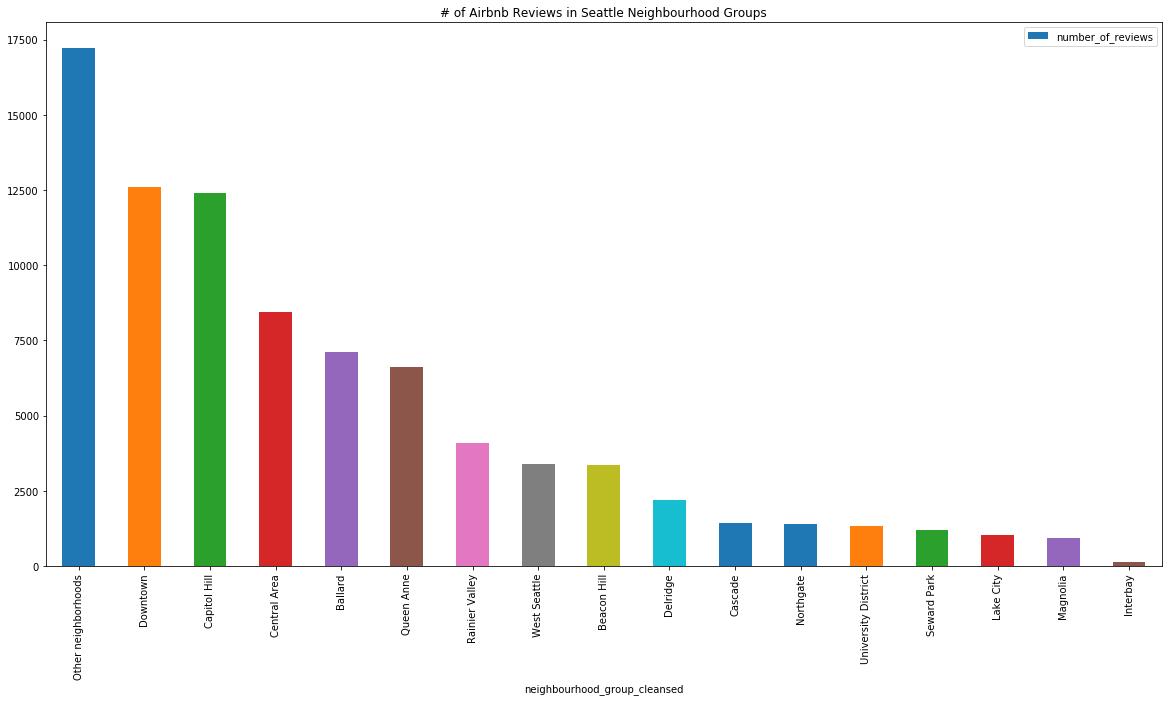

In [39]:
print(areas_and_reviews_2)

areas_and_reviews_2.plot(kind = "bar", figsize = (20,10), legend = True)
plt.title("# of Airbnb Reviews in Seattle Neighbourhood Groups")

#### Average Price of Airbnb Listing in Seattle Neighbourhood Groups

In [43]:
areas_and_prices = airbnb_listing_df.groupby(by = ["neighbourhood_group_cleansed"])["price"].mean()[::-1].sort_values(ascending = False)

DataError: No numeric types to aggregate

In [42]:
print(areas_and_prices)

areas_and_prices.plot(kind = "bar", figsize = (20,10), legend = True)
plt.title("Average Price of Airbnb Listing in Seattle Neighbour Groups")

2516     $99.00
2161     $99.00
2       $975.00
1066     $95.00
2162     $95.00
1712     $95.00
284      $95.00
2517     $90.00
572      $90.00
1914     $90.00
1931     $89.00
1710     $88.00
2137     $88.00
573      $88.00
555      $85.00
0        $85.00
66       $85.00
2145     $84.00
1929     $80.00
686      $80.00
1065     $76.00
2518    $750.00
1912     $75.00
1913     $75.00
1711     $75.00
283      $75.00
3028     $70.00
1167     $70.00
2321     $70.00
1915     $69.00
         ...   
280     $300.00
576     $275.00
2146    $275.00
558     $250.00
1164    $229.00
2323    $200.00
2401    $200.00
1163    $200.00
556     $190.00
68      $175.00
65      $170.00
2158    $150.00
688     $150.00
1       $150.00
281     $150.00
282     $149.00
575     $145.00
687     $145.00
1063    $129.00
574     $125.00
1713    $125.00
2514    $120.00
2322    $110.00
3025    $106.00
2148    $105.00
2324    $100.00
1064    $100.00
3       $100.00
3026    $100.00
1067    $100.00
Name: price, Length: 85,

TypeError: Empty 'DataFrame': no numeric data to plot

#### Average Prices and Number of Reviews on Airbnb Listings in Seattle Neighbour Groups

In [22]:
price_and_review = pd.concat([areas_and_reviews_2,areas_and_prices], axis = 1, sort = True).sort_values(by="number_of_reviews", ascending =  False)

In [23]:
print(price_and_review)


                     number_of_reviews       price
Other neighborhoods              71443  130.806825
Downtown                         51333  204.373095
Capitol Hill                     50031  143.418945
Central Area                     40932  154.694226
Queen Anne                       28131  192.838760
Ballard                          26850  142.504065
West Seattle                     20644  149.571739
Rainier Valley                   19982  120.344418
Beacon Hill                      16947  108.059701
Delridge                         10054   97.113360
Cascade                           7998  179.384615
Northgate                         7537  103.070093
University District               6239  113.242915
Magnolia                          5676  164.676829
Lake City                         5181  121.567742
Seward Park                       3917  152.831325
Interbay                           939  104.625000


#### Reviews per Month of different Neighbourhood Groups in Seattle


In [24]:
reviews_per_month = airbnb_listing_df.groupby(by = ["neighbourhood_group"])["reviews_per_month"].sum()[::-1].sort_values(ascending = False)

In [25]:
reviews_per_month

neighbourhood_group
Other neighborhoods    3344.85
Downtown               2689.21
Capitol Hill           2499.18
Central Area           2102.11
Queen Anne             1458.07
Ballard                1167.25
West Seattle           1050.06
Rainier Valley          985.72
Beacon Hill             891.24
Delridge                597.68
Cascade                 530.29
Northgate               443.68
Magnolia                360.19
University District     307.75
Lake City               283.34
Seward Park             166.93
Interbay                 58.38
Name: reviews_per_month, dtype: float64

#### Finding the neighbourhoods associated with Other Neighbourhood Groups

In [26]:
neighbourhoods = airbnb_listing_df.groupby(by = ["neighbourhood_group"])["neighbourhood"]
#[airbnb_listing_df.neighbourhood_group == "Other neighborhoods"]

In [27]:
other_neighbourhood_list = []

for key, item in neighbourhoods:
    if key == "Other neighborhoods":
        print(key,item)
        other_neighborhoods = item
        other_neighbourhood_list.append(item.tolist())

Other neighborhoods 1                    Roosevelt
3                  Wallingford
4                   Georgetown
8                  Wallingford
13                 Wallingford
15                  Green Lake
16                  Green Lake
17                  Green Lake
31                 Wallingford
33                 Wallingford
34                    Wedgwood
35                  Windermere
37                    Wedgwood
38               Phinney Ridge
41                    Wedgwood
42                    Wedgwood
47                  Green Lake
48                  Green Lake
52                     Fremont
54                     Fremont
55                 Wallingford
56                  Green Lake
76               Phinney Ridge
77                  View Ridge
80                  Crown Hill
84                     Fremont
85               Phinney Ridge
87               Phinney Ridge
90                  Georgetown
94                 Wallingford
                 ...          
8580             Ph

##### List of the neighbourhoods in Seattle associated with Other Neighbourhood Groups

In [28]:
other_neighborhoods.unique().tolist()

['Roosevelt',
 'Wallingford',
 'Georgetown',
 'Green Lake',
 'Wedgwood',
 'Windermere',
 'Phinney Ridge',
 'Fremont',
 'View Ridge',
 'Crown Hill',
 'North Beach/Blue Ridge',
 'Greenwood',
 'Ravenna',
 'Broadview',
 'Bitter Lake',
 'Bryant',
 'Industrial District',
 'Laurelhurst',
 'South Park']

In [29]:
other_neighbourhood_set = set(other_neighbourhood_list[0])

other_neighbourhood_set

{'Bitter Lake',
 'Broadview',
 'Bryant',
 'Crown Hill',
 'Fremont',
 'Georgetown',
 'Green Lake',
 'Greenwood',
 'Industrial District',
 'Laurelhurst',
 'North Beach/Blue Ridge',
 'Phinney Ridge',
 'Ravenna',
 'Roosevelt',
 'South Park',
 'View Ridge',
 'Wallingford',
 'Wedgwood',
 'Windermere'}

#### Number of Reviews in all the neighbourhoods in Seattle

In [30]:
areas_and_reviews_3 = airbnb_listing_df.groupby(by = ["neighbourhood"])["number_of_reviews"].sum()[::-1].sort_values(ascending = False)

In [31]:
areas_and_reviews_3

neighbourhood
Broadway                     36780
Belltown                     21987
Minor                        19078
Fremont                      16246
Wallingford                  14994
First Hill                   10496
North Beacon Hill            10144
Stevens                       8742
Columbia City                 8145
Lower Queen Anne              8080
Greenwood                     8009
Adams                         7742
West Woodland                 7539
East Queen Anne               7228
Atlantic                      6927
North Queen Anne              6907
Mann                          6756
University District           6239
West Queen Anne               5916
Green Lake                    5756
Central Business District     5650
Phinney Ridge                 5641
Pike-Market                   5525
Mount Baker                   5445
North Admiral                 5385
Mid-Beacon Hill               5001
Loyal Heights                 4957
Ravenna                       4479
Whitti

#### Number of Reviews in these neighbourhoods that make up Other Neighbourhood Group

In [32]:
areas_and_reviews_3.loc[other_neighbourhood_set]

neighbourhood
Roosevelt                  2847
Bitter Lake                1085
Windermere                  557
Phinney Ridge              5641
Crown Hill                 2080
South Park                  666
Wedgwood                    975
North Beach/Blue Ridge      965
Greenwood                  8009
Green Lake                 5756
Fremont                   16246
View Ridge                 1000
Industrial District         161
Broadview                  1799
Laurelhurst                 837
Ravenna                    4479
Georgetown                 1581
Wallingford               14994
Bryant                     1765
Name: number_of_reviews, dtype: int64

#### Prices of Airbnb in all the Neighbourhoods in Seattle

In [33]:
areas_and_prices_2 = airbnb_listing_df.groupby(by = ["neighbourhood"])["price"].mean()[::-1].sort_values(ascending = False)

In [34]:
areas_and_prices_2

neighbourhood
Harrison/Denny-Blaine        330.027778
Central Business District    250.503676
South Lake Union             245.850000
West Queen Anne              244.689394
Pike-Market                  236.748768
Portage Bay                  228.533333
Briarcliff                   212.478261
Belltown                     195.643911
Pioneer Square               193.537313
Madison Park                 189.807692
Sunset Hill                  189.290909
Industrial District          186.333333
Madrona                      185.619048
First Hill                   182.413249
North Beach/Blue Ridge       181.266667
Fauntleroy                   181.062500
Alki                         180.870000
North Queen Anne             180.783439
Cedar Park                   179.727273
East Queen Anne              179.634483
Lower Queen Anne             178.445498
Holly Park                   172.250000
Lawton Park                  165.146341
Green Lake                   160.625000
International District    

#### Prices of Airbnb in the Neighbourhoods that make up Other Neighbourhoods

In [35]:
areas_and_prices_2.loc[other_neighbourhood_set]

neighbourhood
Roosevelt                 115.035714
Bitter Lake                88.585366
Windermere                157.545455
Phinney Ridge             131.157534
Crown Hill                107.023810
South Park                 87.666667
Wedgwood                  100.342105
North Beach/Blue Ridge    181.266667
Greenwood                 109.920398
Green Lake                160.625000
Fremont                   144.244966
View Ridge                124.272727
Industrial District       186.333333
Broadview                 110.450000
Laurelhurst               134.235294
Ravenna                   116.925926
Georgetown                117.826087
Wallingford               139.724458
Bryant                    119.272727
Name: price, dtype: float64

#### Dropping Other  Neighbourhoods and adding the individual neighbourhoods in that Group

#### Reviews

In [36]:
areas_and_reviews_cleaned = areas_and_reviews_2.copy(deep =True)

In [37]:

areas_and_reviews_cleaned.drop("Other neighborhoods", inplace = True)
areas_and_reviews_cleaned

neighbourhood_group
Downtown               51333
Capitol Hill           50031
Central Area           40932
Queen Anne             28131
Ballard                26850
West Seattle           20644
Rainier Valley         19982
Beacon Hill            16947
Delridge               10054
Cascade                 7998
Northgate               7537
University District     6239
Magnolia                5676
Lake City               5181
Seward Park             3917
Interbay                 939
Name: number_of_reviews, dtype: int64

In [38]:
areas_and_reviews_cleaned = areas_and_reviews_cleaned.append(areas_and_reviews_3.loc[other_neighbourhood_set]).sort_values(ascending = False)

In [39]:
areas_and_reviews_cleaned

Downtown                  51333
Capitol Hill              50031
Central Area              40932
Queen Anne                28131
Ballard                   26850
West Seattle              20644
Rainier Valley            19982
Beacon Hill               16947
Fremont                   16246
Wallingford               14994
Delridge                  10054
Greenwood                  8009
Cascade                    7998
Northgate                  7537
University District        6239
Green Lake                 5756
Magnolia                   5676
Phinney Ridge              5641
Lake City                  5181
Ravenna                    4479
Seward Park                3917
Roosevelt                  2847
Crown Hill                 2080
Broadview                  1799
Bryant                     1765
Georgetown                 1581
Bitter Lake                1085
View Ridge                 1000
Wedgwood                    975
North Beach/Blue Ridge      965
Interbay                    939
Laurelhu

#### Prices 

In [40]:
areas_and_prices_cleaned = areas_and_prices.copy(deep =True)

In [41]:
areas_and_prices_cleaned.drop("Other neighborhoods", inplace = True)

In [42]:
areas_and_prices_cleaned

neighbourhood_group
Downtown               204.373095
Queen Anne             192.838760
Cascade                179.384615
Magnolia               164.676829
Central Area           154.694226
Seward Park            152.831325
West Seattle           149.571739
Capitol Hill           143.418945
Ballard                142.504065
Lake City              121.567742
Rainier Valley         120.344418
University District    113.242915
Beacon Hill            108.059701
Interbay               104.625000
Northgate              103.070093
Delridge                97.113360
Name: price, dtype: float64

In [43]:
areas_and_prices_cleaned = areas_and_prices_cleaned.append(areas_and_prices_2.loc[other_neighbourhood_set]).sort_values(ascending = False)

In [44]:
areas_and_prices_cleaned 

Downtown                  204.373095
Queen Anne                192.838760
Industrial District       186.333333
North Beach/Blue Ridge    181.266667
Cascade                   179.384615
Magnolia                  164.676829
Green Lake                160.625000
Windermere                157.545455
Central Area              154.694226
Seward Park               152.831325
West Seattle              149.571739
Fremont                   144.244966
Capitol Hill              143.418945
Ballard                   142.504065
Wallingford               139.724458
Laurelhurst               134.235294
Phinney Ridge             131.157534
View Ridge                124.272727
Lake City                 121.567742
Rainier Valley            120.344418
Bryant                    119.272727
Georgetown                117.826087
Ravenna                   116.925926
Roosevelt                 115.035714
University District       113.242915
Broadview                 110.450000
Greenwood                 109.920398
B

#### Number of Reviews Per Month in all the neighbourhoods in Seattle

In [45]:
reviews_per_month_2 = airbnb_listing_df.groupby(by = ["neighbourhood"])["reviews_per_month"].sum()[::-1].sort_values(ascending = False)

In [46]:
reviews_per_month_2

neighbourhood
Broadway                     1695.70
Belltown                     1206.00
Minor                         999.09
Wallingford                   667.72
Fremont                       662.71
Stevens                       543.58
North Beacon Hill             522.24
First Hill                    470.34
Lower Queen Anne              463.04
Greenwood                     405.51
Columbia City                 391.89
North Queen Anne              373.54
Atlantic                      363.70
East Queen Anne               350.55
Adams                         349.21
Pike-Market                   338.14
Mann                          337.43
University District           307.75
West Woodland                 302.10
Central Business District     298.13
Phinney Ridge                 285.21
Green Lake                    279.99
West Queen Anne               270.94
North Admiral                 254.65
Alki                          249.08
Loyal Heights                 237.28
Mid-Beacon Hill         

#### Reviews Per Month in these neighbourhoods that make up Other Neighbourhood Group

In [47]:
reviews_per_month_2.loc[other_neighbourhood_set]

neighbourhood
Roosevelt                 165.25
Bitter Lake                74.43
Windermere                 30.51
Phinney Ridge             285.21
Crown Hill                 90.25
South Park                 37.05
Wedgwood                   57.87
North Beach/Blue Ridge     44.44
Greenwood                 405.51
Green Lake                279.99
Fremont                   662.71
View Ridge                 40.39
Industrial District         7.94
Broadview                  84.16
Laurelhurst                40.83
Ravenna                   197.86
Georgetown                 82.34
Wallingford               667.72
Bryant                     90.39
Name: reviews_per_month, dtype: float64

#### Dropping Other Neighbourhoods and adding the individual neighbourhoods in that Group

In [48]:
reviews_per_month_cleaned = reviews_per_month.copy(deep =True)

In [49]:
reviews_per_month_cleaned.drop("Other neighborhoods", inplace = True)

In [50]:
reviews_per_month_cleaned

neighbourhood_group
Downtown               2689.21
Capitol Hill           2499.18
Central Area           2102.11
Queen Anne             1458.07
Ballard                1167.25
West Seattle           1050.06
Rainier Valley          985.72
Beacon Hill             891.24
Delridge                597.68
Cascade                 530.29
Northgate               443.68
Magnolia                360.19
University District     307.75
Lake City               283.34
Seward Park             166.93
Interbay                 58.38
Name: reviews_per_month, dtype: float64

In [51]:
reviews_per_month_cleaned = reviews_per_month_cleaned.append(reviews_per_month_2.loc[other_neighbourhood_set]).sort_values(ascending = False)

In [52]:
reviews_per_month_cleaned

Downtown                  2689.21
Capitol Hill              2499.18
Central Area              2102.11
Queen Anne                1458.07
Ballard                   1167.25
West Seattle              1050.06
Rainier Valley             985.72
Beacon Hill                891.24
Wallingford                667.72
Fremont                    662.71
Delridge                   597.68
Cascade                    530.29
Northgate                  443.68
Greenwood                  405.51
Magnolia                   360.19
University District        307.75
Phinney Ridge              285.21
Lake City                  283.34
Green Lake                 279.99
Ravenna                    197.86
Seward Park                166.93
Roosevelt                  165.25
Bryant                      90.39
Crown Hill                  90.25
Broadview                   84.16
Georgetown                  82.34
Bitter Lake                 74.43
Interbay                    58.38
Wedgwood                    57.87
North Beach/Bl

#### Revised Reviews of Neighbourhood Groups and Prices of Airbnb in Seattle

#### Total Reviews

Text(0.5, 1.0, '# of Airbnb Reviews in Revised Seattle Neighbourhood Groups')

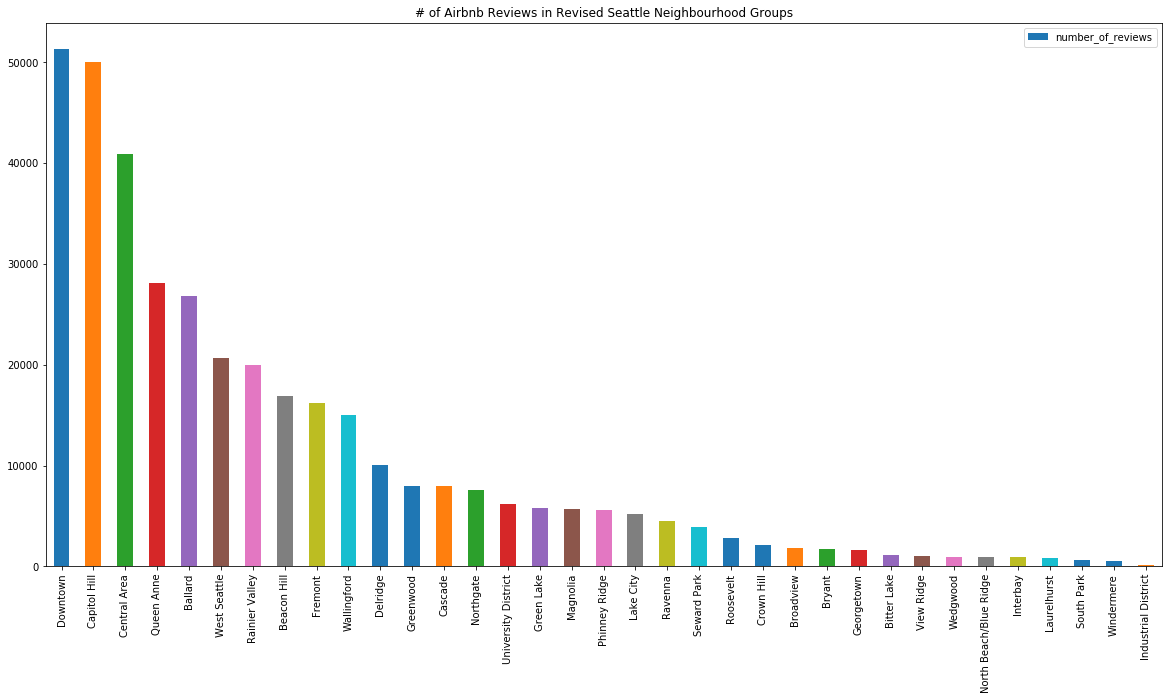

In [53]:
areas_and_reviews_cleaned.plot(kind = "bar", figsize = (20,10), legend = True)

plt.title("# of Airbnb Reviews in Revised Seattle Neighbourhood Groups")


#### Reviews Per Month

Text(0.5, 1.0, 'Reviews Per Month of Revised Airbnb Listing in Seattle Neighbourhood Groups')

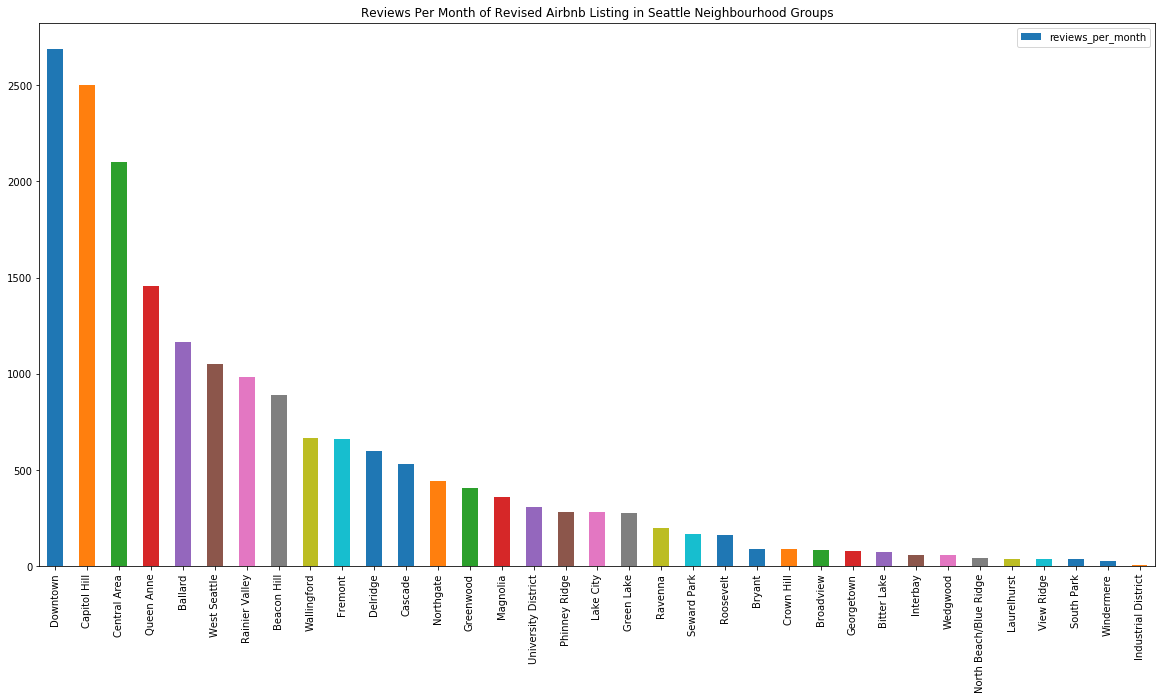

In [54]:
reviews_per_month_cleaned.plot(kind = "bar", figsize = (20,10), legend = True)
plt.title("Reviews Per Month of Revised Airbnb Listing in Seattle Neighbourhood Groups")

#### Airbnb Prices

Text(0.5, 1.0, 'Average Price of Revised Airbnb Listing in Seattle Neighbourhood Groups')

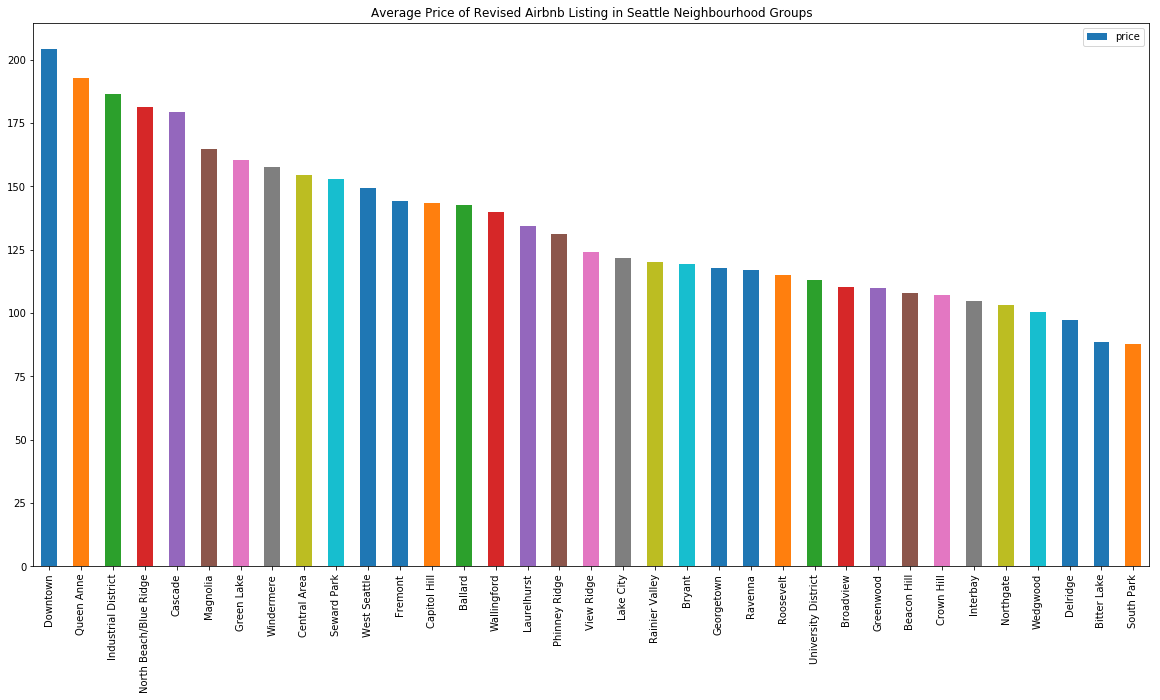

In [55]:
areas_and_prices_cleaned.plot(kind = "bar", figsize = (20,10), legend = True)
plt.title("Average Price of Revised Airbnb Listing in Seattle Neighbourhood Groups")

#### Airbnb Prices of the Highest Visited Neighbourhood Groups in Seattle

Text(0.5, 1.0, 'Average Price of Revised Airbnb Listing in Seattle Neighbourhoods with atleast 10,000 Reviews')

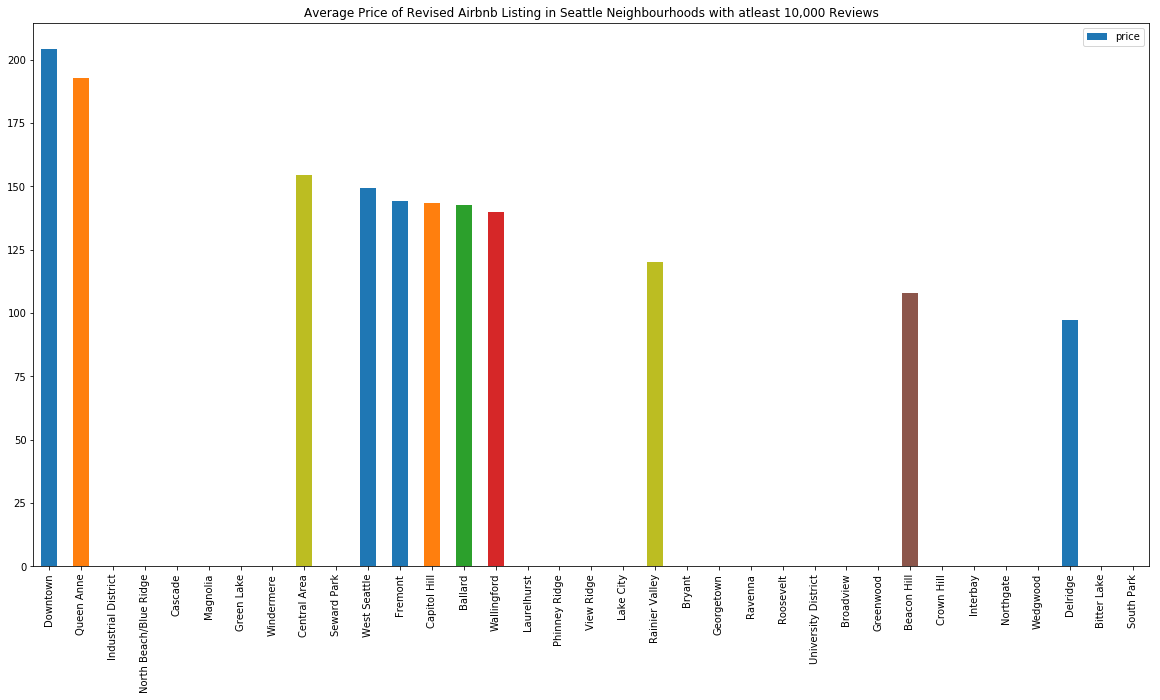

In [56]:
areas_and_prices_cleaned.where(areas_and_reviews_cleaned > 10000).plot(kind = "bar", figsize = (20,10), legend = True)
plt.title("Average Price of Revised Airbnb Listing in Seattle Neighbourhoods with atleast 10,000 Reviews")

##### Prices are spread out from the top to the bottom of the spectrum.

##### Business Question:
##### How does number of reviews drive the Airbnb Prices in Seattle?

##### We are going to monitor standard deviation of Airbnb Prices in different Neighbour Groups to analyze how stable prices are in popular neighbourhood groups 

In [57]:
areas_and_prices_3_std = airbnb_listing_df.groupby(by = ["neighbourhood_group"])["price"].std()[::-1].sort_values(ascending = False)

In [58]:
areas_and_prices_3_std

neighbourhood_group
Central Area           264.360811
Queen Anne             213.872775
Seward Park            166.955947
Magnolia               150.380864
University District    130.444665
Lake City              128.935654
Cascade                121.790664
Rainier Valley         118.107044
Ballard                114.272809
Capitol Hill           106.830272
Other neighborhoods    103.457490
West Seattle           103.104772
Downtown               101.731055
Northgate               82.423273
Delridge                66.388143
Beacon Hill             66.344113
Interbay                48.515118
Name: price, dtype: float64

In [59]:
areas_and_prices_4_std = airbnb_listing_df.groupby(by = ["neighbourhood"])["price"].std()[::-1].sort_values(ascending = False)

In [60]:
areas_and_prices_4_std.loc[other_neighbourhood_set]

neighbourhood
Roosevelt                  79.219756
Bitter Lake                54.620956
Windermere                156.052716
Phinney Ridge             105.274399
Crown Hill                 83.076365
South Park                 43.812272
Wedgwood                   73.870331
North Beach/Blue Ridge    146.699066
Greenwood                  82.563452
Green Lake                141.925903
Fremont                    98.393991
View Ridge                 75.638351
Industrial District       130.615211
Broadview                  77.827538
Laurelhurst                55.996126
Ravenna                   103.783357
Georgetown                 97.096322
Wallingford               108.540179
Bryant                     96.067194
Name: price, dtype: float64

In [61]:
areas_and_prices_std_cleaned = areas_and_prices_3_std.copy(deep =True)

In [62]:
areas_and_prices_std_cleaned.drop("Other neighborhoods", inplace = True)

In [63]:
areas_and_prices_std_cleaned

neighbourhood_group
Central Area           264.360811
Queen Anne             213.872775
Seward Park            166.955947
Magnolia               150.380864
University District    130.444665
Lake City              128.935654
Cascade                121.790664
Rainier Valley         118.107044
Ballard                114.272809
Capitol Hill           106.830272
West Seattle           103.104772
Downtown               101.731055
Northgate               82.423273
Delridge                66.388143
Beacon Hill             66.344113
Interbay                48.515118
Name: price, dtype: float64

In [64]:
areas_and_prices_std_cleaned = areas_and_prices_std_cleaned.append(areas_and_prices_4_std.loc[other_neighbourhood_set]).sort_values(ascending = False)

In [65]:
areas_and_prices_std_cleaned

Central Area              264.360811
Queen Anne                213.872775
Seward Park               166.955947
Windermere                156.052716
Magnolia                  150.380864
North Beach/Blue Ridge    146.699066
Green Lake                141.925903
Industrial District       130.615211
University District       130.444665
Lake City                 128.935654
Cascade                   121.790664
Rainier Valley            118.107044
Ballard                   114.272809
Wallingford               108.540179
Capitol Hill              106.830272
Phinney Ridge             105.274399
Ravenna                   103.783357
West Seattle              103.104772
Downtown                  101.731055
Fremont                    98.393991
Georgetown                 97.096322
Bryant                     96.067194
Crown Hill                 83.076365
Greenwood                  82.563452
Northgate                  82.423273
Roosevelt                  79.219756
Broadview                  77.827538
V

Text(0.5, 1.0, 'STD of Prices of Revised Airbnb Listing in Seattle Neighbourhood Groups')

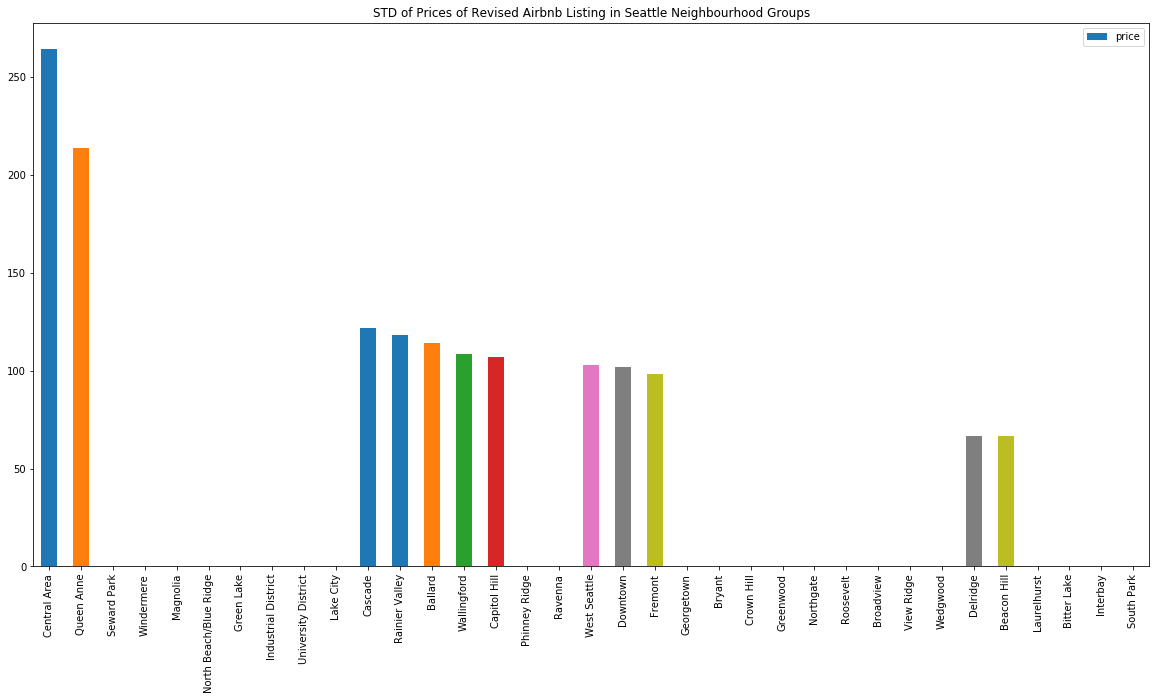

In [66]:
areas_and_prices_std_cleaned.where(reviews_per_month_cleaned > 500).plot(kind = "bar", figsize = (20,10), legend = True)
plt.title("STD of Prices of Revised Airbnb Listing in Seattle Neighbourhood Groups")

###### Airbnb host have are most comptitive in Central Area and Queen Anne Neighbourhood Groups, since the price variations is highest here.

Although, the 3 highest priced areas includes Downtown apart from Central Area, and Queen Anne. 

The variation in prices here may be due to the fact that alot of listings are taken frequently off the market. 
This is just an initial hypothesis for high variation in prices or it is u just a high completive neighbour group since it is slightly off centered from the Downtown and host have to be very competitive in prices. 

In [67]:
max_prices = airbnb_listing_df.groupby(by = ["neighbourhood_group"])["price"].quantile(q = .95, interpolation = 'linear')[::-1].sort_values(ascending = False)

In [68]:
max_prices

neighbourhood_group
Queen Anne             454.00
Cascade                450.00
Magnolia               393.50
Downtown               352.00
West Seattle           350.70
Ballard                350.00
Seward Park            338.10
Lake City              332.50
Central Area           327.85
Other neighborhoods    325.00
Capitol Hill           300.00
University District    300.00
Rainier Valley         299.00
Northgate              267.15
Beacon Hill            250.00
Delridge               219.40
Interbay               176.75
Name: price, dtype: float64

In [69]:
mid_prices = airbnb_listing_df.groupby(by = ["neighbourhood_group"])["price"].quantile(q = .5, interpolation = 'linear')[::-1].sort_values(ascending = False)

In [70]:
mid_prices

neighbourhood_group
Downtown               189.0
Cascade                142.0
Queen Anne             137.0
Magnolia               122.0
Capitol Hill           119.0
West Seattle           110.0
Seward Park            105.0
Ballard                105.0
Other neighborhoods    100.0
Central Area           100.0
Interbay                96.0
Beacon Hill             95.0
University District     86.0
Rainier Valley          85.0
Northgate               81.0
Delridge                79.0
Lake City               78.0
Name: price, dtype: float64

###### After analyzing the data. 

Downtown is stable and completitive. 

The variation in prices between its max to mid in Queen Anne and Central Area is very high, it makes sense why standard deviation is very high in these areas. 

#### Analysis 

In [71]:
airbnb_listing_df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,8.740000e+03,8.740000e+03,8740.000000,8740.000000,8740.000000,8740.000000,8740.000000,7691.000000,8740.000000,8740.000000
mean,1.685464e+07,4.878413e+07,47.626403,-122.333693,152.228375,3.691419,42.772769,2.462089,22.570252,138.483295
std,8.318420e+06,5.572707e+07,0.045696,0.031548,141.676868,13.235492,63.760075,2.427051,62.737811,130.909168
min,2.318000e+03,2.000000e+01,47.496037,-122.419637,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,1.012474e+07,7.978940e+06,47.606366,-122.354144,80.000000,1.000000,3.000000,0.565000,1.000000,14.000000
50%,1.833052e+07,2.632438e+07,47.621423,-122.332098,119.000000,2.000000,17.000000,1.690000,1.000000,89.000000
75%,2.348393e+07,7.212044e+07,47.661255,-122.312031,189.000000,2.000000,55.000000,3.820000,5.000000,263.000000
max,3.005116e+07,2.250343e+08,47.736128,-122.234026,5400.000000,400.000000,717.000000,46.410000,311.000000,365.000000


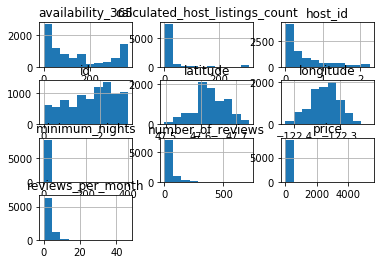

In [72]:
airbnb_listing_df.hist();

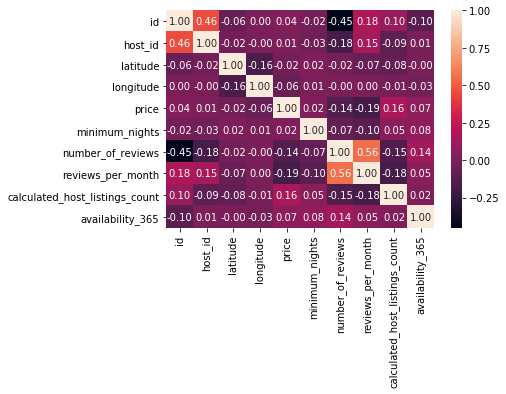

In [73]:
sns.heatmap(airbnb_listing_df.corr(), annot = True, fmt = '.2f')

In [3]:
airbnb_listing_df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,8.740000e+03,8.740000e+03,8740.000000,8740.000000,8740.000000,8740.000000,8740.000000,7691.000000,8740.000000,8740.000000
mean,1.685464e+07,4.878413e+07,47.626403,-122.333693,152.228375,3.691419,42.772769,2.462089,22.570252,138.483295
std,8.318420e+06,5.572707e+07,0.045696,0.031548,141.676868,13.235492,63.760075,2.427051,62.737811,130.909168
min,2.318000e+03,2.000000e+01,47.496037,-122.419637,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,1.012474e+07,7.978940e+06,47.606366,-122.354144,80.000000,1.000000,3.000000,0.565000,1.000000,14.000000
50%,1.833052e+07,2.632438e+07,47.621423,-122.332098,119.000000,2.000000,17.000000,1.690000,1.000000,89.000000
75%,2.348393e+07,7.212044e+07,47.661255,-122.312031,189.000000,2.000000,55.000000,3.820000,5.000000,263.000000
max,3.005116e+07,2.250343e+08,47.736128,-122.234026,5400.000000,400.000000,717.000000,46.410000,311.000000,365.000000


#### Finding missing values

In [32]:
airbnb_listing_df.isnull().sum()

id                                   0
name                                 0
host_id                              0
host_name                            0
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       1048
reviews_per_month                 1049
calculated_host_listings_count       0
availability_365                     0
dtype: int64

#### Imputing Missing Values

In [33]:
reviews_per_month_mean = airbnb_listing_df.reviews_per_month.mean()

last_review_mode = airbnb_listing_df.last_review.mode()[0]

print(reviews_per_month_mean)

print(last_review_mode)

2.4620894552073804
11/12/2018


In [34]:
airbnb_listing_df.reviews_per_month.fillna(reviews_per_month_mean, inplace = True)


In [35]:
airbnb_listing_df["last_review"].fillna(last_review_mode, inplace = True)

In [36]:
airbnb_listing_df.isnull().sum()

id                                0
name                              0
host_id                           0
host_name                         0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

#### Cleaning the data

In [37]:
airbnb_listing_df.drop(columns = ["name", "host_name"])

,id,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2318,2536,Central Area,Madrona,47.610819,-122.290816,Entire home/apt,296,4,20,9/18/2018,0.160000,3,345
1,4291,35749,Other neighborhoods,Roosevelt,47.687801,-122.313427,Private room,82,2,63,10/6/2018,0.960000,5,365
2,5682,8993,Delridge,South Delridge,47.523979,-122.359891,Entire home/apt,48,3,461,11/2/2018,4.370000,1,24
3,6606,14942,Other neighborhoods,Wallingford,47.654109,-122.337605,Entire home/apt,90,2,134,10/21/2018,1.180000,3,287
4,9419,30559,Other neighborhoods,Georgetown,47.550620,-122.320135,Private room,65,2,130,9/9/2018,1.290000,5,336
5,9460,30832,Downtown,First Hill,47.608010,-122.328739,Private room,80,3,399,10/28/2018,3.560000,4,133
6,9531,31481,West Seattle,Fairmount Park,47.555389,-122.384739,Entire home/apt,165,2,35,10/8/2018,0.420000,2,267
7,9534,31481,West Seattle,Fairmount Park,47.556236,-122.385980,Entire home/apt,125,2,36,10/29/2018,0.430000,2,352
8,9596,14942,Other neighborhoods,Wallingford,47.654787,-122.336520,Entire home/apt,120,2,76,10/1/2018,0.840000,3,94
9,9909,33360,West Seattle,Fairmount Park,47.565209,-122.373748,Entire home/apt,125,3,57,10/23/2018,3.750000,8,22


In [38]:
airbnb_listing_df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

##### Dropping price 

In [39]:
price_raw = airbnb_listing_df.price

In [40]:
price_raw.head()

0    296
1     82
2     48
3     90
4     65
Name: price, dtype: int64

### Predicting Airbnb Prices  

In [41]:
features_raw = airbnb_listing_df.drop(["price", "name", "host_name", "last_review"], axis = 1)

In [42]:
#features_raw.groupby("host_id")["number_of_reviews"].sum().plot(kind = "bar", figsize = (20,10), legend = True)

In [43]:
features_raw.head()

,id,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,2318,2536,Central Area,Madrona,47.610819,-122.290816,Entire home/apt,4,20,0.16,3,345
1,4291,35749,Other neighborhoods,Roosevelt,47.687801,-122.313427,Private room,2,63,0.96,5,365
2,5682,8993,Delridge,South Delridge,47.523979,-122.359891,Entire home/apt,3,461,4.37,1,24
3,6606,14942,Other neighborhoods,Wallingford,47.654109,-122.337605,Entire home/apt,2,134,1.18,3,287
4,9419,30559,Other neighborhoods,Georgetown,47.550620,-122.320135,Private room,2,130,1.29,5,336


In [44]:
features_raw.columns

Index(['id', 'host_id', 'neighbourhood_group', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

##### Normalize Numerical Data

In [45]:
numerical = ["latitude", "longitude","minimum_nights","number_of_reviews","reviews_per_month","calculated_host_listings_count","availability_365"]

In [46]:
scaler = MinMaxScaler()

features_normalized = features_raw.copy(deep = True)

features_normalized[numerical] = scaler.fit_transform(features_raw[numerical])

In [47]:
# Show an example of a record with scaling applied
features_normalized.head()

,id,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,2318,2536,Central Area,Madrona,0.478077,0.694037,Entire home/apt,0.007519,0.027894,0.003233,0.006452,0.945205
1,4291,35749,Other neighborhoods,Roosevelt,0.798712,0.572216,Private room,0.002506,0.087866,0.020474,0.012903,1.000000
2,5682,8993,Delridge,South Delridge,0.116382,0.321891,Entire home/apt,0.005013,0.642957,0.093966,0.000000,0.065753
3,6606,14942,Other neighborhoods,Wallingford,0.658381,0.441955,Entire home/apt,0.002506,0.186890,0.025216,0.006452,0.786301
4,9419,30559,Other neighborhoods,Georgetown,0.227341,0.536076,Private room,0.002506,0.181311,0.027586,0.012903,0.920548


In [48]:
features_normalized.columns.shape

(12,)

##### Data Processing - Hot-Encoding

In [49]:
#categorical = ["neighbourhood_group","neighbourhood", "room_type"]

In [50]:
features_final = pd.get_dummies(features_normalized)

In [51]:
features_final.columns.shape

(117,)

In [52]:
features_final.head()

,id,host_id,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Ballard,...,neighbourhood_Wedgwood,neighbourhood_West Queen Anne,neighbourhood_West Woodland,neighbourhood_Westlake,neighbourhood_Whittier Heights,neighbourhood_Windermere,neighbourhood_Yesler Terrace,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,2318,2536,0.478077,0.694037,0.007519,0.027894,0.003233,0.006452,0.945205,0,...,0,0,0,0,0,0,0,1,0,0
1,4291,35749,0.798712,0.572216,0.002506,0.087866,0.020474,0.012903,1.000000,0,...,0,0,0,0,0,0,0,0,1,0
2,5682,8993,0.116382,0.321891,0.005013,0.642957,0.093966,0.000000,0.065753,0,...,0,0,0,0,0,0,0,1,0,0
3,6606,14942,0.658381,0.441955,0.002506,0.186890,0.025216,0.006452,0.786301,0,...,0,0,0,0,0,0,0,1,0,0
4,9419,30559,0.227341,0.536076,0.002506,0.181311,0.027586,0.012903,0.920548,0,...,0,0,0,0,0,0,0,0,1,0


#### Missing values imputed with mean for Reviews Per Month

In [53]:
features_final.columns[features_final.isnull().sum() > 1]

Index([], dtype='object')

In [54]:
features_final.reviews_per_month.fillna(features_final.reviews_per_month.mean(), inplace = True)

features_final.columns[features_final.isnull().sum()> 1]

Index([], dtype='object')

#### Shuffle and Split Data

In [55]:
# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    list(price_raw.values), 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape))
print("Testing set has {} samples.".format(X_test.shape))

Training set has (6992, 117) samples.
Testing set has (1748, 117) samples.


##### Creating a Training and Predicting Pipeline

In [28]:
import time
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    #start = time.time # Get start time
    learner.fit(X_train[:sample_size],y_train[:sample_size])
    #end = time.time # Get end time
    
    # Calculate the training time
    #results['train_time'] = time.time - start
        
    # Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    #start = time.time # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    #end = time.time # Get end time
    
    # Calculate the total prediction time
    #results['pred_time'] = time.time - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300],predictions_train, beta = 0.5, average ='micro')
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta = 0.5, average ='micro')
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [29]:
clf_A = GaussianNB()
clf_B = RandomForestClassifier(random_state = 1)
clf_C = AdaBoostClassifier(RandomForestClassifier(), random_state = 1)
clf_D = svclassifier = SVC(kernel='rbf')
clf_E = KNeighborsClassifier(n_neighbors = 15)
#clf_F = AdaBoostClassifier(RandomForestClassifier(), random_state = 1, learning_rate = 1)

samples_100 = int(len(y_train))
samples_10 = int(len(y_train)/10)
samples_1 = int(len(y_train)/100)

# Collect results on the learners
results = {}

for clf in [clf_A, clf_B, clf_C, clf_D, clf_E]:
    clf_name = clf.__class__.__name__
    
    results[clf_name] = {}
    
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train, y_train, X_test, y_test)



GaussianNB trained on 69 samples.
GaussianNB trained on 699 samples.
GaussianNB trained on 6992 samples.
RandomForestClassifier trained on 69 samples.
RandomForestClassifier trained on 699 samples.
RandomForestClassifier trained on 6992 samples.
AdaBoostClassifier trained on 69 samples.
AdaBoostClassifier trained on 699 samples.
AdaBoostClassifier trained on 6992 samples.
SVC trained on 69 samples.
SVC trained on 699 samples.
SVC trained on 6992 samples.
KNeighborsClassifier trained on 69 samples.
KNeighborsClassifier trained on 699 samples.
KNeighborsClassifier trained on 6992 samples.


In [30]:
results


{'GaussianNB': {0: {'acc_train': 0.19333333333333333,
   'acc_test': 0.02345537757437071,
   'f_train': 0.19333333333333333,
   'f_test': 0.02345537757437071},
  1: {'acc_train': 0.22,
   'acc_test': 0.036613272311212815,
   'f_train': 0.22,
   'f_test': 0.036613272311212815},
  2: {'acc_train': 0.07333333333333333,
   'acc_test': 0.04748283752860412,
   'f_train': 0.07333333333333333,
   'f_test': 0.04748283752860412}},
 'RandomForestClassifier': {0: {'acc_train': 0.25666666666666665,
   'acc_test': 0.028604118993135013,
   'f_train': 0.25666666666666665,
   'f_test': 0.028604118993135013},
  1: {'acc_train': 0.9933333333333333,
   'acc_test': 0.07379862700228833,
   'f_train': 0.9933333333333333,
   'f_test': 0.07379862700228833},
  2: {'acc_train': 0.99,
   'acc_test': 0.14244851258581237,
   'f_train': 0.99,
   'f_test': 0.14244851258581237}},
 'AdaBoostClassifier': {0: {'acc_train': 0.25,
   'acc_test': 0.033752860411899316,
   'f_train': 0.25,
   'f_test': 0.033752860411899316},


##### Random Forest Prediction Ensemble is most effective

#### Grid Search on Random Forest Classifier

In [36]:

# Initialize the classifier
clf = RandomForestClassifier( random_state = 1, n_jobs = -1, oob_score =  True)

# Create the parameters list you wish to tune, using a dictionary if needed.

parameters = {"n_estimators": [10,20,50,100,200,400,500,600,800,1000], 
              "max_features": ["auto"],
              "min_samples_leaf" :[5,10,20,30,50,100,150,200]
             }

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=.5, average = "micro")

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring = scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train,y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5, average = "micro")))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5, average = "micro")))

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: 

C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob esti

C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob esti

Unoptimized model
------
Accuracy score on testing data: 0.1424
F-score on testing data: 0.1424

Optimized Model
------
Final accuracy score on the testing data: 0.1510
Final F-score on the testing data: 0.1510


In [37]:
linear_mean_sq_err = mean_squared_error(y_test, predictions)
linear_mean_sq_err ** 1/2

7556.296910755149

Linear Regression Model

In [38]:
lm_model = LinearRegression(normalize=True)
lm_model.fit(X_train, y_train)
y_test_preds = lm_model.predict(X_test)# Predictions here
r2_test = r2_score(y_test, y_test_preds)

r2_test

0.19273153802001353

In [39]:
linear_mean_sq_err = mean_squared_error(y_test, y_test_preds)
linear_mean_sq_err ** 1/2

5634.874928489702

R^2 (coefficient of determination) regression score function.

Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.

#### Applying K-nearest Neighbours to Predict Airbnb prices in Seattle

In [56]:
features_normalized.head()

,id,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,2318,2536,Central Area,Madrona,0.478077,0.694037,Entire home/apt,0.007519,0.027894,0.003233,0.006452,0.945205
1,4291,35749,Other neighborhoods,Roosevelt,0.798712,0.572216,Private room,0.002506,0.087866,0.020474,0.012903,1.000000
2,5682,8993,Delridge,South Delridge,0.116382,0.321891,Entire home/apt,0.005013,0.642957,0.093966,0.000000,0.065753
3,6606,14942,Other neighborhoods,Wallingford,0.658381,0.441955,Entire home/apt,0.002506,0.186890,0.025216,0.006452,0.786301
4,9419,30559,Other neighborhoods,Georgetown,0.227341,0.536076,Private room,0.002506,0.181311,0.027586,0.012903,0.920548


In [57]:
features_knn = features_normalized.drop(["neighbourhood","id", "host_id"], axis = 1)

In [58]:
features_knn.neighbourhood_group.unique().shape

(17,)

In [59]:
features_knn.head()

,neighbourhood_group,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Central Area,0.478077,0.694037,Entire home/apt,0.007519,0.027894,0.003233,0.006452,0.945205
1,Other neighborhoods,0.798712,0.572216,Private room,0.002506,0.087866,0.020474,0.012903,1.000000
2,Delridge,0.116382,0.321891,Entire home/apt,0.005013,0.642957,0.093966,0.000000,0.065753
3,Other neighborhoods,0.658381,0.441955,Entire home/apt,0.002506,0.186890,0.025216,0.006452,0.786301
4,Other neighborhoods,0.227341,0.536076,Private room,0.002506,0.181311,0.027586,0.012903,0.920548


In [60]:
features_knn = pd.get_dummies(features_knn)

In [61]:
features_knn.head()

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Ballard,neighbourhood_group_Beacon Hill,neighbourhood_group_Capitol Hill,...,neighbourhood_group_Northgate,neighbourhood_group_Other neighborhoods,neighbourhood_group_Queen Anne,neighbourhood_group_Rainier Valley,neighbourhood_group_Seward Park,neighbourhood_group_University District,neighbourhood_group_West Seattle,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,0.478077,0.694037,0.007519,0.027894,0.003233,0.006452,0.945205,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.798712,0.572216,0.002506,0.087866,0.020474,0.012903,1.000000,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,0.116382,0.321891,0.005013,0.642957,0.093966,0.000000,0.065753,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.658381,0.441955,0.002506,0.186890,0.025216,0.006452,0.786301,0,0,0,...,0,1,0,0,0,0,0,1,0,0
4,0.227341,0.536076,0.002506,0.181311,0.027586,0.012903,0.920548,0,0,0,...,0,1,0,0,0,0,0,0,1,0


In [62]:
knn_model = KNeighborsRegressor(algorithm = "brute")

In [63]:
knn_model.fit(X_train,y_train)

KNeighborsRegressor(algorithm='brute', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

In [78]:
knn_pred = knn_model.predict(X_test)
knn_r2_test = r2_score(y_test, knn_pred)

knn_r2_test

-0.010580002932049304

In [79]:
knn_mean_sq_err = mean_squared_error(y_test, knn_pred)

knn_mean_sq_err ** (1/2)

118.77731274483058

#### Crossvalidation of KNN Classifier

In [71]:
# Creating foldings K for KNN
knn_neighbors = list(range(1,100))

# subsetting just the odd ones
neighbors = list(filter(lambda x: x % 2 != 0, knn_neighbors))

# CV scores list

cv_scores = []

# perform 10-fold cross validation

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(knn, X_train, y_train, cv = 10, scoring = "accuracy")
    cv_scores.append(scores.mean())

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot b

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot b

In [72]:
knn_neighbors[MSE.index(min(MSE))]
len(cv_scores)
print(neighbors)

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99]


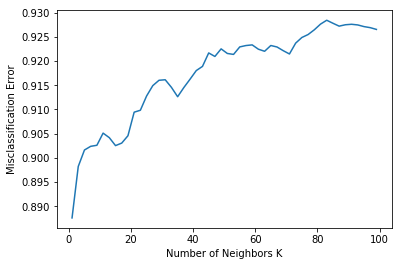

In [75]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
#print("The optimal number of neighbors is {}".format(optimal_k))
# plot misclassification error vs k
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

#### Crossvalidation of KNN Regressor

In [85]:
# Creating foldings K for KNN
knn_neighbors = list(range(1,100))

# subsetting just the odd ones
neighbors = list(filter(lambda x: x % 2 != 0, knn_neighbors))

# CV scores list

cv_scores_knn_reg = []

# perform 10-fold cross validation

for k in neighbors:
    knn = KNeighborsRegressor(n_neighbors = k, n_jobs = -1,algorithm = "brute")
    scores = cross_val_score(knn, X_train, y_train, cv = 10, scoring = "explained_variance", n_jobs = -1)
    cv_scores_knn_reg.append(scores.mean())

In [64]:
cv_scores_knn_reg

NameError: name 'cv_scores_knn_reg' is not defined

#### Error Rate for Different K values for KNN Regressor

In [68]:
rmse_val = [] #to store rmse values for different k
r2_val = []
for K in range(100):
    K = K+1
    model = KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train, y_train)  #fit the model
    pred_knn_reg =model.predict(X_test) #make prediction on test set
    rmse_knn_reg = (mean_squared_error(y_test,pred_knn_reg)) ** (1/2) #calculate rmse
    r2_knn_reg = r2_score(y_test, pred_knn_reg)
    rmse_val.append(rmse_knn_reg) #store rmse values
    r2_val.append(r2_knn_reg)
    print('RMSE value for k = ' , K , 'is:', rmse_knn_reg)
    print('R2 value for k = ' , K , 'is:', r2_knn_reg)

RMSE value for k =  1 is: 144.89640424588433
R2 value for k =  1 is: -0.5038998835121409
RMSE value for k =  2 is: 127.86233345199622
R2 value for k =  2 is: -0.17108646413555584
RMSE value for k =  3 is: 122.21854136564923
R2 value for k =  3 is: -0.06998552365987898
RMSE value for k =  4 is: 119.34476356381529
R2 value for k =  4 is: -0.02025902761338827
RMSE value for k =  5 is: 118.77731274483058
R2 value for k =  5 is: -0.010580002932049304
RMSE value for k =  6 is: 117.38898724417928
R2 value for k =  6 is: 0.012906206853418811
RMSE value for k =  7 is: 116.72286143326986
R2 value for k =  7 is: 0.024076983431610466
RMSE value for k =  8 is: 116.36539126160673
R2 value for k =  8 is: 0.030045465653102843
RMSE value for k =  9 is: 115.1864112758083
R2 value for k =  9 is: 0.04960048762243874
RMSE value for k =  10 is: 115.70343456945022
R2 value for k =  10 is: 0.041049453230302735
RMSE value for k =  11 is: 115.06769649781553
R2 value for k =  11 is: 0.051558502020058294
RMSE val

RMSE value for k =  92 is: 114.6326185261132
R2 value for k =  92 is: 0.058717172887978175
RMSE value for k =  93 is: 114.66715925941477
R2 value for k =  93 is: 0.05814983877650437
RMSE value for k =  94 is: 114.64669146024681
R2 value for k =  94 is: 0.058486044531826153
RMSE value for k =  95 is: 114.61989883722218
R2 value for k =  95 is: 0.05892605166294018
RMSE value for k =  96 is: 114.60062615488256
R2 value for k =  96 is: 0.0592424974918091
RMSE value for k =  97 is: 114.59486321174907
R2 value for k =  97 is: 0.05933711120997931
RMSE value for k =  98 is: 114.59369643178388
R2 value for k =  98 is: 0.05935626636221525
RMSE value for k =  99 is: 114.60477031965044
R2 value for k =  99 is: 0.059174457294839944
RMSE value for k =  100 is: 114.63915900737243
R2 value for k =  100 is: 0.05860975811545399


In [82]:
sorted(SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

#### RMSE KNN Regressor Plot

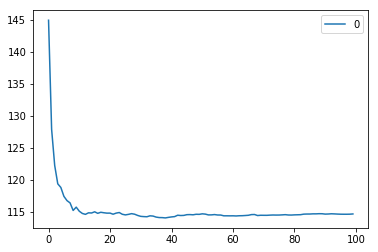

In [67]:
#plotting the rmse values against k values
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

#### R2 KNN Regressor Plot

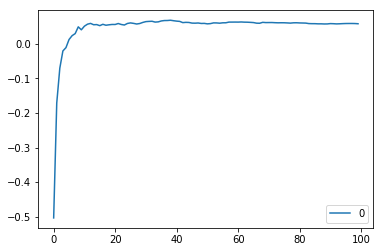

In [71]:
#plotting the rmse values against k values
curve = pd.DataFrame(r2_val) #elbow curve 
curve.plot()

#### Predicting Airbnb Prices in Seattle on test data set using KNN Regressor  

In [70]:

#predicting on the test set and creating submission file
predict_knn_reg_2 = model.predict(X_test)


In [76]:
knn_mean_sq_err_2 = mean_squared_error(y_test, predict_knn_reg_2)

knn_mean_sq_err_2 ** (1/2)

114.63915900737243

#### Grid Search on KNN Regressor

In [75]:
params = {'n_neighbors':[30,31,32,33,34,35,36,37,38,39,40]}

knn_reg = KNeighborsRegressor()

model_knn_reg = GridSearchCV(knn_reg, params, cv=5)
model_knn_reg.fit(X_train,y_train)
model_knn_reg.best_params_

{'n_neighbors': 34}

In [ ]:
knn = KNeighborsClassifier(n_neighbors = k)



#### K = 34 - KNN Regressor Predictions

In [82]:
knn_pred_final = KNeighborsRegressor(n_neighbors = 34)
model_knn_reg.fit(X_train,y_train)
predict_knn_reg_final = model.predict(X_test)


In [83]:
knn_mean_sq_err_3 = mean_squared_error(y_test, predict_knn_reg_final)

rmse_knn_final = knn_mean_sq_err_3 ** (1/2)

rmse_knn_final

114.63915900737243

In [84]:
r2_knn_final = r2_score(y_test, predict_knn_reg_final )

r2_knn_final

0.05860975811545399